## Score Model w/ Weather EDA

### Objective

* Evaluation of basic linear model using weather factors and previous scores

### Rationale

*  Why This?  Before establishing a baseline model, the performance implications of various model choices need to be explored.

*  Why Me?  Because I will be building the baseline model, I am the logical choice

*  Why Now?  Data from a reproducible pipeline is now available; understanding model choices is necessary before continuing on the project critical path of model implementation

### Requirements

*  Pandas 0.24.2
*  Scikit-learn 0.21.2
*  Matplotlib 3.1.0

### Input / Output

*  This notebook is expected to be in `models/notebooks/eda`

*  The input weather data is in a file `models/wx_model_data/wx_model.csv`

*  The input score data is in a file `models/score_model_data/scores.csv`

*  The output models are stored in a file `models/score_model_data/linear_model_fits.csv`

### Import / Set-Up

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get weather data
wx_df = pd.read_csv('../../wx_model_data/wx_model.csv', parse_dates = ['date'])
# Get scores data
scores_df = pd.read_csv('../../score_model_data/scores.csv', parse_dates = ['time'])

In [3]:
wx_df.head()

,Unnamed: 0,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var,course_id
0,0,2018-12-09,49.491667,68.116667,3.919444,13.133333,90.988889,0.000000,2.100778,2.822686,2.915556,490.203981,41.108702,0
1,1,2019-01-27,56.642593,66.362963,3.916667,12.466667,73.714815,0.000000,2.674324,2.326601,1.582222,301.056529,227.954035,0
2,2,2018-11-11,62.987163,59.560057,5.091894,15.866667,26.821613,0.000000,2.632290,3.792724,2.382222,115.436274,111.370212,0
3,3,2019-02-03,53.603704,243.125926,6.662963,20.400000,91.900000,0.001870,-5.654134,-2.807737,6.106667,17.509657,49.623507,0
4,4,2019-01-06,51.505556,153.133333,4.384722,20.933333,89.798611,0.105625,0.829178,-3.227827,6.995556,214.376551,906.500313,0


In [4]:
scores_df.head()

,id,Name,Raw,Handicap,Adjusted,time,course_id
0,0,Mark Shannon,61,-12.40,48.60,2019-01-19 08:00:00,1
1,1,Jacob Kermish-Wells,60,-10.72,49.28,2019-01-19 08:00:00,1
2,2,Luiz Celeste,55,-5.23,49.77,2019-01-19 08:00:00,1
3,3,Tu Tran,59,-9.07,49.93,2019-01-19 08:00:00,1
4,4,Matty Angell,53,-1.50,51.50,2019-01-19 08:00:00,1


In [5]:
# Clean out duplicated indexes
wx_df = wx_df.drop(columns = 'Unnamed: 0')
scores_df = scores_df.drop(columns = 'id')

In [6]:
# Sort prior to merge
wx_df = wx_df.sort_values(by = ['date','course_id'])
scores_df = scores_df.sort_values(by= ['time','course_id','Name'])

In [7]:
all_df = pd.merge_asof(scores_df, wx_df, by = 'course_id', left_on= 'time', right_on = 'date',
                       direction = 'backward', tolerance = pd.Timedelta('1d') )
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
0,Alex Torres,68,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andy Leaf,53,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anthony McGinnis,78,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aurelius Lewicki,57,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Billy Manger,58,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop any rows that do not have weather data
all_df = all_df.dropna(subset = ['weighted_T'])
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
478,Ben Horst,65,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
479,Bob Montes,54,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
480,Dennis Warsen,52,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
481,Gonzalo Arestizabal,63,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
482,Greg Mann,58,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685


In [9]:
len(all_df)

3057

In [10]:
all_df.columns

Index(['Name', 'Raw', 'Handicap', 'Adjusted', 'time', 'course_id', 'date',
       'weighted_T', 'weighted_w_dir', 'weighted_w_spd', 'weighted_w_gust',
       'weighted_rh', 'weighted_precip', 'weighted_w_u', 'weighted_w_v',
       'w_gust_var', 'w_dir_var', 'w_uv_var'],
      dtype='object')

In [11]:
def model_player_performance(player : str, course : int):
    """Given a player name and course id, return model parameters indicating the effects of weather on expected score.
    The model will return a dictionary with coefficients for easy identification"""
    
    model_dict = {}
    model_dict['player'] = player
    model_dict['course_id'] = course
    player_df = all_df[(all_df['Name'] == player) & (all_df['course_id'] == course)]
    # Stop early if no games are found
    if len(player_df) == 0:
        model_dict['nomatch'] = 1
        return model_dict
    # else...
    # Replace index with the cumulative number of games played, and make that into a column
    player_df = player_df.reset_index()
    player_df = player_df.drop(columns = ['index'])
    player_df = player_df.reset_index()
    model_dict['n_values'] = len(player_df)
    # Set list to hold model items and coefficient names
    model_factors = ['index','weighted_T','weighted_w_spd','weighted_w_gust','weighted_precip','w_dir_var']
    coeff_names = ['cumgame_coeff','T_coeff','wspd_coeff','wgust_coeff','precip_coeff','dirvar_coeff']
    # Assumes first factor will be time-dependent and the rest weather-dependent
    # Check for any weather variable that is highly correlated with time (i.e. model_factor[0]) and remove it
    removed_corr = 0
    for ix, factor in enumerate(model_factors):
        if ix == 0:
            continue
        corr = player_df.corr()[model_factors[0]][factor]
        if corr > 0.8:
            model_factors.pop(ix)
            coeff_names.pop(ix)
            removed_corr += 1
    model_dict['removed_corr'] = removed_corr
    if not(model_factors):
        model_dict['no_uncorrelated'] = 1
        return model_dict
    # else...
    # If the number of data points is too small, go with time-dependence only
    if len(model_factors) > len(player_df) - 2:
        model_factors = ['index']
        coeff_names = ['cumgame_coeff']
    X = player_df[model_factors].values
    y = player_df['Raw'].values
    # Fit if there are enough values, fit with ElasticNet
    if len(player_df) > 3:
        scaler = StandardScaler()
        lr = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 3, 
                        max_iter = 5000, random_state=42)
        pipeline = make_pipeline(scaler, lr)
        pipeline.fit(X,y)
        ypred = pipeline.predict(X)
        model_dict['prediction_score'] = pipeline.score(X,y)
        scaled_coeff = pipeline['elasticnetcv'].coef_ 
        coeff_tuple = np.true_divide(scaled_coeff, pipeline['standardscaler'].scale_)
        for ix, coeff in enumerate(coeff_tuple):
            model_dict[coeff_names[ix]] = coeff_tuple[ix]
        scaled_intercept = pipeline['elasticnetcv'].intercept_
        model_dict['intercept'] = scaled_intercept - np.dot(coeff_tuple, pipeline['standardscaler'].mean_)
        model_dict['mse'] = mean_squared_error(y, ypred)
    else:  #Just use average value
        model_dict['intercept'] = np.mean(y)
        model_dict['mse'] = np.std(y)
        
    return model_dict    

In [12]:
#Make list of player names
player_names = all_df['Name'].unique()
perf_dicts = []
for player_name in player_names:
    for course_id in range(all_df['course_id'].max() + 1):
        perf_dict = model_player_performance(player_name, course_id)
        perf_dicts.append(perf_dict)
            
perf_model_df = pd.DataFrame(perf_dicts)
perf_model_df.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018412132943881332, tolerance: 0.0017714285714285716
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002118905096158752, tolerance: 0.0017714285714285716
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024058198131422515, tolerance: 0.0017714285714285716
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordina

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002725341159275807, tolerance: 0.0004666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002725341159275807, tolerance: 0.0004666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002725341159275807, tolerance: 0.0004666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002725341159275807, tolerance: 0.0004666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002725341159275807, tolerance: 0.0004666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002725341159275807, tolerance: 0.0004666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13942007657149347, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13942007657149347, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13942007657149347, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_de

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13942007657149347, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13942007657149347, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13942007657149347, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_de

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005246286639813746, tolerance: 0.002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005246286639813746, tolerance: 0.002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005246286639813746, tolerance: 0.002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective d

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027661166023467132, tolerance: 0.002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027661166023467132, tolerance: 0.002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027661166023467132, tolerance: 0.002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective d

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032906125149779086, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032906125149779086, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032906125149779086, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032906125149779086, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032906125149779086, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032906125149779086, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056192344883871925, tolerance: 0.002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056192344883871925, tolerance: 0.002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056192344883871925, tolerance: 0.002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective d

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020114041561988927, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020114041561988927, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020114041561988927, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013343431941885697, tolerance: 0.0004666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013343431941885697, tolerance: 0.0004666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013343431941885697, tolerance: 0.0004666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordin

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016703465422565955, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016703465422565955, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016703465422565955, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016703465422565955, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016703465422565955, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016703465422565955, tolerance: 0.0020666666666666667
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6126951371353044, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6126951371353044, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6126951371353044, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_desce

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6126951371353044, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6126951371353044, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6126951371353044, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_desce

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16695040738628286, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16695040738628286, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16695040738628286, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objec

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16695040738628286, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16695040738628286, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16695040738628286, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objec

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05901861509818396, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05901861509818396, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05901861509818396, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_de

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005232302750200202, tolerance: 0.0002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005232302750200202, tolerance: 0.0002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005232302750200202, tolerance: 0.0002
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objec

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03175462244039817, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03175462244039817, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03175462244039817, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objec

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03175462244039817, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03175462244039817, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03175462244039817, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objec

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0834689770082222, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0834689770082222, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0834689770082222, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objectiv

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004425563446234904, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004425563446234904, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004425563446234904, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Ob

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004425563446234904, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004425563446234904, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004425563446234904, tolerance: 0.000875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Ob

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002476234176516101, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002476234176516101, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002476234176516101, tolerance: 0.0012666666666666666
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.974536900054453, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.974536900054453, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.974536900054453, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.974536900054453, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.974536900054453, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.974536900054453, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.609391483290693, tolerance: 0.01032
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.609391483290693, tolerance: 0.01032
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.609391483290693, tolerance: 0.01032
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did 

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06300567728469275, tolerance: 0.01032
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06300567728469275, tolerance: 0.01032
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06300567728469275, tolerance: 0.01032
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objectiv

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0004722481602357, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0004722481602357, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0004722481602357, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3213185162297094, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3213185162297094, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3213185162297094, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01134594595802696, tolerance: 0.01032
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01134594595802696, tolerance: 0.01032
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01134594595802696, tolerance: 0.01032
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objectiv

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056014461245098346, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056014461245098346, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056014461245098346, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_de

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12897131206027268, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12897131206027268, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12897131206027268, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_desce

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12897131206027268, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12897131206027268, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01302981784972701, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_desce

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01302981784972701, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01302981784972701, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01302981784972701, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_desce

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.138425209521003, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.138425209521003, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.138425209521003, tolerance: 0.010719999999999999
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00154445550561777, tolerance: 0.0015333333333333334
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016121954789279913, tolerance: 0.0015333333333333334
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016741647168905804, tolerance: 0.0015333333333333334
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did no

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005465054159371707, tolerance: 0.005200000000000001
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0066892575612653715, tolerance: 0.005200000000000001
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011301916323639194, tolerance: 0.005200000000000001
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_d

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003984870821135189, tolerance: 0.003171428571428571
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021158988702703496, tolerance: 0.003171428571428571
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.061614362474886164, tolerance: 0.003171428571428571
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_de

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006986506537153048, tolerance: 0.005
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010349490252583138, tolerance: 0.005
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005341105945486646, tolerance: 0.005
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective d

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21473704912751046, tolerance: 0.005
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23118783962281952, tolerance: 0.005
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24777522193595658, tolerance: 0.005
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did 

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
0,NaN,0,NaN,NaN,NaN,NaN,NaN,1.0,Ben Horst,NaN,NaN,NaN,NaN,NaN
1,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0,Ben Horst,NaN,NaN,NaN,NaN,NaN
2,NaN,2,-0.0,-0.000382,67.739914,14.874146,9.0,NaN,Ben Horst,58.668983,0.088649,1.0,0.039611,0.110993
3,NaN,0,NaN,NaN,NaN,NaN,NaN,1.0,Bob Montes,NaN,NaN,NaN,NaN,NaN
4,NaN,1,0.0,NaN,52.600000,6.640000,5.0,NaN,Bob Montes,NaN,0.000000,0.0,NaN,NaN


In [13]:
perf_model_df.removed_corr.value_counts()

0.0    473
1.0     61
2.0     45
3.0      8
Name: removed_corr, dtype: int64

In [14]:
perf_model_coeff_removed = perf_model_df[perf_model_df.removed_corr > 0]
perf_model_coeff_removed.head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
2,NaN,2,-0.0,-0.000382,67.739914,14.874146,9.0,NaN,Ben Horst,58.668983,0.088649,1.0,0.039611,0.110993
14,NaN,2,NaN,NaN,63.500000,5.500000,2.0,NaN,Greg Mann,NaN,NaN,3.0,NaN,NaN
17,NaN,2,NaN,NaN,59.500000,5.500000,2.0,NaN,Gregg LaComb,NaN,NaN,3.0,NaN,NaN
27,NaN,0,NaN,NaN,55.500000,0.500000,2.0,NaN,Nelson Vasquez,NaN,NaN,2.0,NaN,NaN
31,NaN,1,NaN,NaN,62.000000,3.000000,2.0,NaN,Pete D'Agostino,NaN,NaN,1.0,NaN,NaN


In [15]:
perf_model_coeff_removed[perf_model_coeff_removed.n_values > 3]

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
2,NaN,2,-0.452264,-0.000943,60.936444,3.510594,8.0,NaN,Ben Horst,563.096769,0.795747,1.0,0.965936,0.0
122,NaN,2,-0.000000,NaN,52.750000,8.187500,4.0,NaN,Greg Breazeale,NaN,0.000000,1.0,NaN,NaN


In [15]:
perf_model_small = perf_model_df.dropna(subset=['T_coeff'])
print(len(perf_model_small))
perf_model_small.head()

137


,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
5,-0.169666,2,0.000000,0.000382,61.804732,9.655933,23.0,NaN,Bob Montes,0.0,0.308048,0.0,0.351630,0.0
6,-0.000000,0,0.000000,0.000000,51.000000,3.272727,11.0,NaN,Dennis Warsen,0.0,0.000000,0.0,0.000000,0.0
7,-0.290334,1,-0.104976,-0.000455,74.091710,4.060424,14.0,NaN,Dennis Warsen,0.0,0.748151,0.0,0.410773,-0.0
8,-0.000000,2,-0.000000,-0.000243,52.484281,13.200213,53.0,NaN,Dennis Warsen,0.0,0.171262,0.0,0.238605,0.0
10,-0.000000,1,0.306465,0.000777,65.040982,6.324352,8.0,NaN,Gonzalo Arestizabal,0.0,0.494052,0.0,-0.337044,-0.0


(array([96.,  9., 32.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

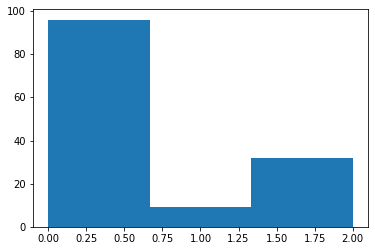

In [16]:
plt.hist(perf_model_small['course_id'],bins=3)

(array([ 1.,  1.,  0.,  0.,  0.,  4.,  3.,  3.,  3.,  4.,  2.,  8., 94.,
         2.,  0.,  3.,  0.,  2.,  3.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-0.59950629, -0.55211675, -0.50472722, -0.45733769, -0.40994815,
        -0.36255862, -0.31516909, -0.26777955, -0.22039002, -0.17300048,
        -0.12561095, -0.07822142, -0.03083188,  0.01655765,  0.06394719,
         0.11133672,  0.15872625,  0.20611579,  0.25350532,  0.30089485,
         0.34828439,  0.39567392,  0.44306346,  0.49045299,  0.53784252,
         0.58523206,  0.63262159,  0.68001113,  0.72740066,  0.77479019,
         0.82217973]),
 <a list of 30 Patch objects>)

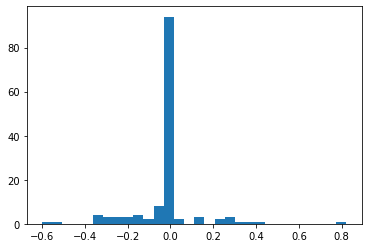

In [56]:
plt.hist(perf_model_small['T_coeff'], bins = 30)

(array([27., 37., 43., 20.,  5.,  1.,  1.,  0.,  2.,  1.]),
 array([ 0.13198504,  4.61878654,  9.10558803, 13.59238953, 18.07919102,
        22.56599252, 27.05279402, 31.53959551, 36.02639701, 40.5131985 ,
        45.        ]),
 <a list of 10 Patch objects>)

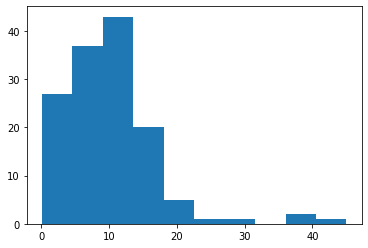

In [18]:
plt.hist(perf_model_small['mse'])

In [20]:
perf_model_df.to_csv('../../score_model_data/score_model3_na.csv')
len(perf_model_df)

1449

(array([  2.,   0.,   2.,   4., 101.,  16.,   6.,   2.,   3.,   1.]),
 array([-1.00743398, -0.80090928, -0.59438457, -0.38785987, -0.18133516,
         0.02518954,  0.23171424,  0.43823895,  0.64476365,  0.85128836,
         1.05781306]),
 <a list of 10 Patch objects>)

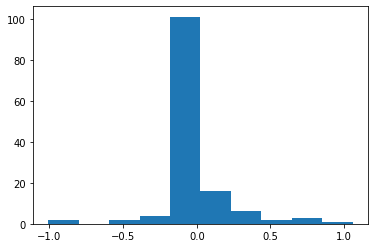

In [21]:
plt.hist(perf_model_small['cumgame_coeff'])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 117.,  12.,   3.,   2.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-4344.93330522, -4026.86881225, -3708.80431928, -3390.73982631,
        -3072.67533333, -2754.61084036, -2436.54634739, -2118.48185442,
        -1800.41736145, -1482.35286848, -1164.28837551,  -846.22388254,
         -528.15938957,  -210.0948966 ,   107.96959637,   426.03408934,
          744.09858231,  1062.16307528,  1380.22756825,  1698.29206122,
         2016.35655419,  2334.42104717,  2652.48554014,  2970.55003311,
         3288.61452608,  3606.67901905,  3924.74351202,  4242.80800499,
         4560.87249796,  4878.93699093,  5197.0014839 ]),
 <a list of 30 Patch objects>)

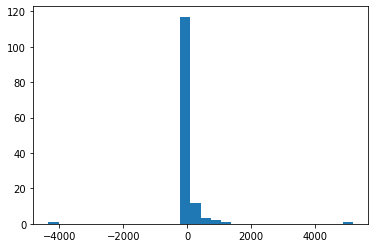

In [52]:
plt.hist(perf_model_small['precip_coeff'], bins = 30)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   2., 108.,  16.,   3.,   1.,
          1.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-9.77098005, -9.24171317, -8.71244628, -8.1831794 , -7.65391252,
        -7.12464564, -6.59537876, -6.06611188, -5.536845  , -5.00757811,
        -4.47831123, -3.94904435, -3.41977747, -2.89051059, -2.36124371,
        -1.83197682, -1.30270994, -0.77344306, -0.24417618,  0.2850907 ,
         0.81435758,  1.34362446,  1.87289135,  2.40215823,  2.93142511,
         3.46069199,  3.98995887,  4.51922575,  5.04849264,  5.57775952,
         6.1070264 ]),
 <a list of 30 Patch objects>)

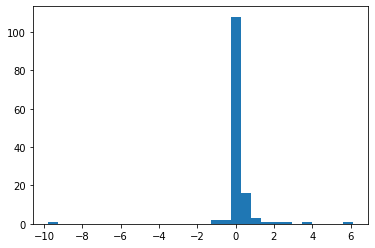

In [54]:
plt.hist(perf_model_small['wspd_coeff'], bins = 30)

(array([ 1.,  1.,  0.,  1.,  1.,  1.,  2.,  1., 10., 93., 18.,  5.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-1.2769474 , -1.13746565, -0.9979839 , -0.85850215, -0.7190204 ,
        -0.57953864, -0.44005689, -0.30057514, -0.16109339, -0.02161164,
         0.11787012,  0.25735187,  0.39683362,  0.53631537,  0.67579712,
         0.81527888,  0.95476063,  1.09424238,  1.23372413,  1.37320589,
         1.51268764,  1.65216939,  1.79165114,  1.93113289,  2.07061465,
         2.2100964 ,  2.34957815,  2.4890599 ,  2.62854165,  2.76802341,
         2.90750516]),
 <a list of 30 Patch objects>)

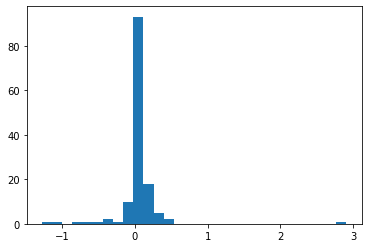

In [53]:
plt.hist(perf_model_small['wgust_coeff'], bins = 30)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  6., 99.,
        13.,  5.,  4.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-0.00948445, -0.00873572, -0.007987  , -0.00723827, -0.00648955,
        -0.00574082, -0.00499209, -0.00424337, -0.00349464, -0.00274592,
        -0.00199719, -0.00124846, -0.00049974,  0.00024899,  0.00099772,
         0.00174644,  0.00249517,  0.00324389,  0.00399262,  0.00474135,
         0.00549007,  0.0062388 ,  0.00698753,  0.00773625,  0.00848498,
         0.0092337 ,  0.00998243,  0.01073116,  0.01147988,  0.01222861,
         0.01297733]),
 <a list of 30 Patch objects>)

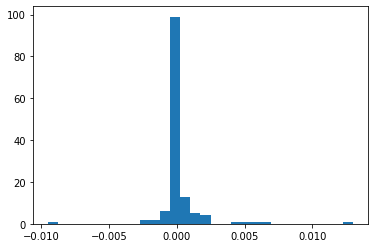

In [55]:
plt.hist(perf_model_small['dirvar_coeff'], bins = 30)

(array([62., 11., 10., 14., 11.,  7.,  8.,  6.,  4.,  4.]),
 array([0.        , 0.09891006, 0.19782012, 0.29673018, 0.39564024,
        0.4945503 , 0.59346035, 0.69237041, 0.79128047, 0.89019053,
        0.98910059]),
 <a list of 10 Patch objects>)

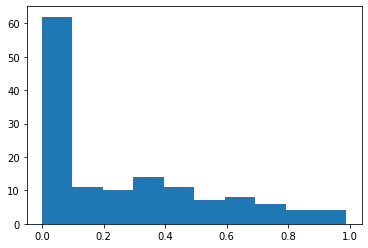

In [26]:
plt.hist(perf_model_small['prediction_score'])

In [27]:
zeros = []
coeff_count = []
for row in perf_model_small.iterrows():
    tmp_count = 0
    if row[1]['cumgame_coeff'] == 0:
        tmp_count += 1
    if row[1]['T_coeff'] == 0:
        tmp_count += 1
    if row[1]['precip_coeff'] == 0:
        tmp_count += 1
    if row[1]['wgust_coeff'] == 0:
        tmp_count += 1
    if row[1]['wspd_coeff'] == 0:
        tmp_count += 1
    if row[1]['dirvar_coeff'] == 0:
        tmp_count += 1
    zeros.append(tmp_count)
    coeff_count.append(6 - tmp_count)
perf_model_small['coeff_count'] = coeff_count
perf_model_small.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,coeff_count
5,-0.169666,2,0.000000,0.000382,61.804732,9.655933,23.0,NaN,Bob Montes,0.0,0.308048,0.0,0.351630,0.0,3
6,-0.000000,0,0.000000,0.000000,51.000000,3.272727,11.0,NaN,Dennis Warsen,0.0,0.000000,0.0,0.000000,0.0,0
7,-0.290334,1,-0.104976,-0.000455,74.091710,4.060424,14.0,NaN,Dennis Warsen,0.0,0.748151,0.0,0.410773,-0.0,4
8,-0.000000,2,-0.000000,-0.000243,52.484281,13.200213,53.0,NaN,Dennis Warsen,0.0,0.171262,0.0,0.238605,0.0,2
10,-0.000000,1,0.306465,0.000777,65.040982,6.324352,8.0,NaN,Gonzalo Arestizabal,0.0,0.494052,0.0,-0.337044,-0.0,3


In [28]:
perf_model_small.coeff_count.value_counts()

0    34
1    29
6    25
5    14
2    13
4    12
3    10
Name: coeff_count, dtype: int64

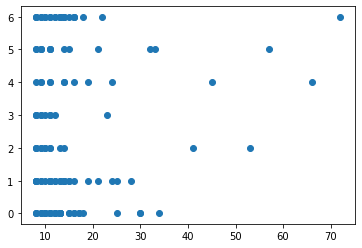

In [29]:
plt.scatter(x=perf_model_small.n_values, y=perf_model_small.coeff_count)

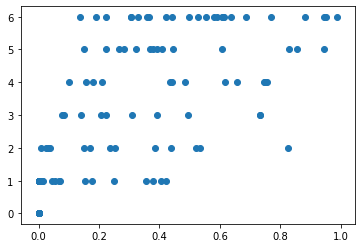

In [30]:
plt.scatter(x=perf_model_small.prediction_score, y=perf_model_small.coeff_count)

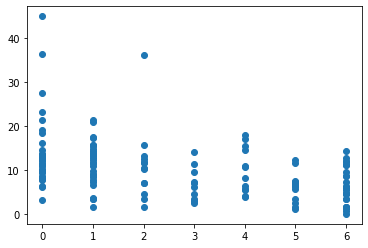

In [31]:
plt.scatter(x=perf_model_small.coeff_count, y=perf_model_small.mse)

In [32]:
perf_model_small.mse.mean()

10.192271019750887

In [33]:
perf_model_small.mean()

T_coeff             -0.018054
course_id            0.532847
cumgame_coeff        0.027277
dirvar_coeff         0.000237
intercept           58.025442
mse                 10.192271
n_values            15.051095
nomatch                   NaN
precip_coeff        58.116113
prediction_score     0.255012
removed_corr         0.000000
wgust_coeff          0.025847
wspd_coeff           0.126638
coeff_count          2.576642
dtype: float64

In [34]:
perf_model_small.std()

T_coeff               0.153982
course_id             0.849317
cumgame_coeff         0.218718
dirvar_coeff          0.001767
intercept             9.588979
mse                   6.782303
n_values             10.527500
nomatch                    NaN
precip_coeff        606.277779
prediction_score      0.284394
removed_corr          0.000000
wgust_coeff           0.321554
wspd_coeff            1.127547
coeff_count           2.274289
dtype: float64

In [35]:
perf_model_small[['player','course_id','mse','coeff_count']].sort_values(by='mse')

,player,course_id,mse,coeff_count
660,Kevin Eckert,0,0.131985,6
678,Marquis Oliver,0,0.778662,6
1035,Thor Scordelis,0,1.142763,5
789,Chris Johengen,0,1.474757,6
969,Jake Ward,0,1.505148,6
338,Roger Cansler,2,1.583332,6
1023,Marquis Mallen,0,1.664741,6
1074,Randy Waters,0,1.707004,2
19,Jon Braidman,1,1.717023,5
135,Mike Degnan,0,1.747718,6


In [36]:
perf_model_small.sort_values(by='prediction_score',ascending=False).head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,coeff_count
660,0.377356,0,0.846340,0.012977,22.350489,0.131985,8.0,NaN,Kevin Eckert,25.773605,0.989101,0.0,-0.050190,2.359296,6
678,-0.153644,0,-0.832425,0.002379,54.907600,0.778662,8.0,NaN,Marquis Oliver,5197.001484,0.952629,0.0,0.314557,0.512362,6
338,-0.125277,2,0.292396,0.005165,44.774090,1.583332,13.0,NaN,Roger Cansler,91.414951,0.944554,0.0,-0.589836,6.107026,6
1035,0.822180,0,1.057813,0.001660,22.310796,1.142763,9.0,NaN,Thor Scordelis,0.000000,0.943969,0.0,-1.006158,0.871446,5
789,0.431888,0,0.084785,0.006438,31.572650,1.474757,14.0,NaN,Chris Johengen,329.814281,0.880606,0.0,-1.276947,3.958807,6


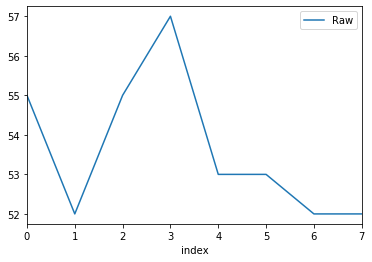

In [37]:
bh = all_df[all_df['Name'] == 'Dan Santini']
bh = bh.reset_index()
bh = bh.drop(columns=['index'])
bh = bh.reset_index()
bh.plot('index','Raw')

In [133]:
single_factor = perf_model_small.loc[perf_model_small.coeff_count == 2]

In [139]:
single_factor.precip_coeff.value_counts()

0.0    8
Name: precip_coeff, dtype: int64

In [38]:
perf_model_df.mean()

T_coeff             -0.018054
course_id            1.000000
cumgame_coeff        0.063950
dirvar_coeff         0.000233
intercept           61.043802
mse                  4.389759
n_values             5.207836
nomatch              1.000000
precip_coeff        58.120120
prediction_score     0.243546
removed_corr         0.298126
wgust_coeff          0.025947
wspd_coeff           0.126525
dtype: float64

In [39]:
perf_model_df.std()

T_coeff               0.153982
course_id             0.816778
cumgame_coeff         0.633783
dirvar_coeff          0.001761
intercept             9.368999
mse                   6.405050
n_values              7.579909
nomatch               0.000000
precip_coeff        604.061036
prediction_score      0.281045
removed_corr          0.667157
wgust_coeff           0.320380
wspd_coeff            1.123425
dtype: float64

In [40]:
precip_impute = perf_model_small.loc[perf_model_small.precip_coeff != 0]
precip_impute = precip_impute.loc[abs(perf_model_small.precip_coeff) > 0.000001]
precip_impute.head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,coeff_count
20,-0.200821,2,-0.080520,-0.000000,65.855125,4.193256,24.0,NaN,Jon Braidman,811.062245,0.744546,0.0,0.328578,0.000000,4
29,-0.022457,2,-0.012274,-0.000166,59.448141,7.397842,13.0,NaN,Nelson Vasquez,-71.101949,0.138956,0.0,0.119397,0.050678,6
32,-0.000000,2,-0.000942,-0.000000,60.241811,15.496337,66.0,NaN,Pete D'Agostino,85.863820,0.101363,0.0,0.061271,0.277786,4
41,-0.001137,2,-0.003171,-0.000094,52.418447,11.146920,72.0,NaN,Steve Willis,76.693005,0.305995,0.0,0.128956,0.693651,6
48,0.281985,0,-0.002393,0.000326,41.622260,4.795455,9.0,NaN,Vince Mardigras,38.586845,0.528602,0.0,-0.046047,-0.537816,6


In [41]:
precip_impute.mean()

T_coeff              -0.006045
course_id             0.452830
cumgame_coeff         0.068242
dirvar_coeff          0.000624
intercept            56.901164
mse                   7.759056
n_values             16.471698
nomatch                    NaN
precip_coeff        150.224670
prediction_score      0.446912
removed_corr          0.000000
wgust_coeff           0.007847
wspd_coeff            0.425546
coeff_count           4.698113
dtype: float64

In [42]:
precip_impute.std()

T_coeff               0.169034
course_id             0.845032
cumgame_coeff         0.244006
dirvar_coeff          0.002203
intercept            10.369699
mse                   5.997616
n_values             13.916791
nomatch                    NaN
precip_coeff        973.263084
prediction_score      0.260602
removed_corr          0.000000
wgust_coeff           0.267075
wspd_coeff            1.102096
coeff_count           1.612272
dtype: float64

In [43]:
T_impute = perf_model_small.loc[perf_model_small.T_coeff != 0]
T_impute = T_impute.loc[abs(T_impute.T_coeff) > 0.0001]
T_impute.mean()['T_coeff'], T_impute.std()['T_coeff']

(-0.04339260343551038, 0.23761968137900413)

In [45]:
len(T_impute), len(precip_impute)

(57, 53)

In [46]:
perf_model_with_zeros = perf_model_df.fillna(0)
perf_model_with_zeros.head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
0,0.0,0,0.0,0.000000,0.000000,0.000000,0.0,1.0,Ben Horst,0.000000,0.000000,0.0,0.000000,0.000000
1,0.0,1,0.0,0.000000,0.000000,0.000000,0.0,1.0,Ben Horst,0.000000,0.000000,0.0,0.000000,0.000000
2,0.0,2,-0.0,-0.000382,67.739914,14.874146,9.0,0.0,Ben Horst,58.668983,0.088649,1.0,0.039611,0.110993
3,0.0,0,0.0,0.000000,0.000000,0.000000,0.0,1.0,Bob Montes,0.000000,0.000000,0.0,0.000000,0.000000
4,0.0,1,0.0,0.000000,52.600000,6.640000,5.0,0.0,Bob Montes,0.000000,0.000000,0.0,0.000000,0.000000


In [47]:
perf_model_with_zeros.to_csv('../../score_model_data/score_model3_fill0.csv')
len(perf_model_with_zeros)

1449

In [51]:
len(all_df)

3057

In [50]:
len(scores_df)

3795

In [49]:
len(wx_df)

235